<a href="https://colab.research.google.com/github/ehddnr301/dacon_motion/blob/master/dacon_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from PIL import Image
import os
import cv2
import glob

from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, concatenate, Input, Flatten, Dense
from tensorflow.keras import Model

import warnings
warnings.filterwarnings("ignore")

In [ ]:
TRAIN_IMG_FOLDER = '/content/gdrive/MyDrive/dacon-motion/train_imgs'

TEST_IMG_FOLDER = '/content/gdrive/MyDrive/dacon-motion/test_imgs'

TRAIN_DF = '/content/gdrive/MyDrive/dacon-motion/train_df.csv'
SUB_DF = '/content/gdrive/MyDrive/dacon-motion/sample_submission.csv'

IMAGE_HEIGHT = 270
IMAGE_WIDTH = 480

In [ ]:
!unzip -o '/content/gdrive/MyDrive/dacon-motion/train_imgs.zip' -d '/content/gdrive/MyDrive/dacon-motion/train_imgs'

In [ ]:
!unzip -o '/content/gdrive/MyDrive/dacon-motion/test_imgs.zip' -d '/content/gdrive/MyDrive/dacon-motion/test_imgs'

In [ ]:
train = pd.read_csv(TRAIN_DF)
submission = pd.read_csv(SUB_DF)

In [ ]:
train.iloc[:,1:49] = train.iloc[:,1:49] / 4 # 1/4 로 리사이즈 할것이기때문
train

,image,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y,left_shoulder_x,left_shoulder_y,right_shoulder_x,right_shoulder_y,left_elbow_x,left_elbow_y,right_elbow_x,right_elbow_y,left_wrist_x,left_wrist_y,right_wrist_x,right_wrist_y,left_hip_x,left_hip_y,right_hip_x,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y,neck_x,neck_y,left_palm_x,left_palm_y,right_palm_x,right_palm_y,spine2(back)_x,spine2(back)_y,spine1(waist)_x,spine1(waist)_y,left_instep_x,left_instep_y,right_instep_x,right_instep_y
0,001-1-1-01-Z17_A-0000001.jpg,261.597408,86.189470,260.413824,82.455056,264.857377,83.621057,255.029449,84.722635,262.000000,85.750000,248.000000,98.500000,263.500000,100.000000,239.000000,92.000000,283.500000,92.750000,250.874311,81.910021,269.500000,85.250000,249.750000,142.500000,261.500000,143.250000,248.750000,173.750000,263.500000,174.500000,245.750000,205.000000,260.50000,207.250000,254.776819,93.441555,253.284340,79.077924,266.750000,83.750000,254.871057,113.750000,256.628943,128.513683,249.644709,206.679503,265.801017,209.706866
1,001-1-1-01-Z17_A-0000003.jpg,267.462670,85.177874,264.652138,81.148423,268.810528,81.398423,260.355749,82.923704,266.398421,83.492115,252.500000,99.500000,269.250000,96.500000,243.500000,99.500000,286.000000,84.250000,251.000000,86.500000,273.500000,81.500000,255.000000,139.250000,267.250000,141.750000,253.250000,145.750000,268.000000,174.250000,250.960945,169.699257,260.50000,207.250000,261.819860,90.507974,254.345778,83.222635,270.296845,80.750000,261.738312,113.515676,264.691558,127.199257,250.566419,174.765676,266.594058,210.374861
2,001-1-1-01-Z17_A-0000005.jpg,271.118976,84.250002,269.679499,80.939472,273.912103,81.310530,265.259971,82.337893,271.615258,83.527365,255.000000,95.250000,270.750000,97.250000,246.000000,90.500000,290.750000,93.000000,256.876855,81.845780,277.750000,85.000000,254.000000,138.000000,265.250000,139.000000,254.500000,168.500000,267.500000,174.000000,246.925788,197.216835,261.00000,206.500000,265.757429,89.669988,260.593694,79.757885,275.250000,83.500000,261.134740,110.513683,263.211036,123.972635,247.359462,202.189472,266.517854,210.437388
3,001-1-1-01-Z17_A-0000007.jpg,260.580012,90.363172,259.476799,86.029451,262.582096,88.478432,254.211036,85.228434,260.541048,89.837895,242.000000,98.000000,252.500000,102.750000,235.453153,84.925788,277.250000,110.250000,242.913733,82.162107,266.703151,95.851577,243.000000,142.750000,250.000000,139.750000,247.750000,175.000000,277.500000,117.250000,247.851575,204.033163,283.25000,147.750000,251.825746,93.544851,245.460582,82.277365,264.351579,93.115260,245.734324,114.527366,247.593781,126.906217,250.326294,207.308442,289.879125,149.847499
4,001-1-1-01-Z17_A-0000009.jpg,264.511599,85.791048,261.679499,82.925791,264.533163,82.945270,257.814701,84.648423,262.453155,84.546845,249.250000,98.250000,263.500000,98.750000,240.250000,105.750000,283.000000,90.000000,247.169076,89.422074,270.000000,84.250000,250.000000,141.750000,260.750000,142.500000,254.250000,168.250000,264.750000,175.250000,249.601575,196.142625,260.00000,206.750000,259.079736,91.548932,249.944355,87.457323,267.412107,83.527365,256.210948,113.421893,258.597772,127.710948,249.656308,201.304730,264.906489,209.941276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4190,642-2-4-31-Z148_E-0000023.jpg,159.312763,195.335565,279.283955,92.666825,274.280807,82.660550,273.863885,88.914469,270.841150,81.409755,267.818415,82.347846,266.364057,98.562036,272.730725,112.912474,257.422434,80.851061,243.100705,53.412110,240.838280,48.238497,245.640829,101.785434,238.119831,84.265216,229.890095,54.447700,227.589678,49.050977,246.719946,111.128149,229.05624,126.607837,214.223625,143.401350,186.308890,168.235180,190.686638,215.

In [ ]:
#submission 파일 불러오기
submission.head(2)

,image,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y,left_shoulder_x,left_shoulder_y,right_shoulder_x,right_shoulder_y,left_elbow_x,left_elbow_y,right_elbow_x,right_elbow_y,left_wrist_x,left_wrist_y,right_wrist_x,right_wrist_y,left_hip_x,left_hip_y,right_hip_x,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y,neck_x,neck_y,left_palm_x,left_palm_y,right_palm_x,right_palm_y,spine2(back)_x,spine2(back)_y,spine1(waist)_x,spine1(waist)_y,left_instep_x,left_instep_y,right_instep_x,right_instep_y
0,649-2-4-32-Z148_A-0000001.jpg,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,649-2-4-32-Z148_A-0000003.jpg,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
train_paths = glob.glob(f'{TRAIN_IMG_FOLDER}/*.jpg')
test_paths = glob.glob(f'{TEST_IMG_FOLDER}/*.jpg')
print(len(train_paths), len(test_paths))

4195 1600


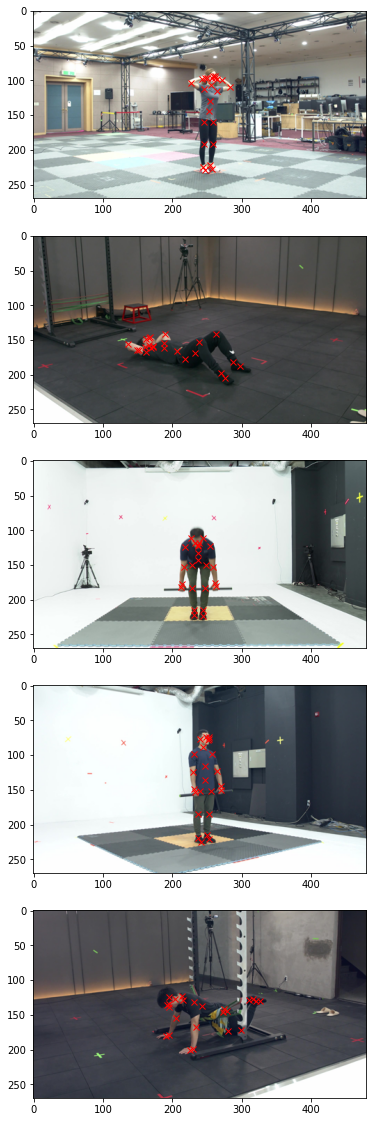

In [ ]:
plt.figure(figsize=(40,20))
count=1

for i in np.random.randint(0,len(train_paths),5):
    
    plt.subplot(5,1, count)
    
    img_sample_path = train_paths[i]
    img_name = img_sample_path.split('/')[6]
    img = Image.open(img_sample_path)
    img = img.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
    img_np = np.array(img)
    key = train[train['image'] == img_name].iloc[0, 1:49]

    keypoint = train.iloc[:,1:49] #위치키포인트 하나씩 확인

    for j in range(0,len(keypoint.columns),2):
        plt.plot(key[j], key[j+1],'rx')
        plt.imshow(img_np)
    
    count += 1

In [ ]:
train['path'] = train_paths

In [ ]:
target_list = list(train.columns)[1:49]

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_dataframe(
    train,
    directory=TRAIN_IMG_FOLDER,
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    x_col="image",
    y_col=target_list,
    class_mode='raw',
    batch_size=8,
)

test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_dataframe(
    submission,
    directory=TEST_IMG_FOLDER,
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    x_col="image",
    y_col=target_list,
    class_mode='raw',
    batch_size=8,
)

Found 4195 validated image filenames.
Found 1600 validated image filenames.


In [ ]:
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.layers import Activation, Convolution2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, Conv2D,MaxPool2D, ZeroPadding2D

In [ ]:
def create_model():
  model = Sequential()

  model.add(Convolution2D(32, (3,3), padding='same', use_bias=False, input_shape=(IMAGE_HEIGHT,IMAGE_WIDTH,3)))
  model.add(LeakyReLU(alpha = 0.1))
  model.add(BatchNormalization())

  model.add(Convolution2D(32, (3,3), padding='same', use_bias=False))
  model.add(LeakyReLU(alpha = 0.1))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))

  model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
  model.add(LeakyReLU(alpha = 0.1))
  model.add(BatchNormalization())

  model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
  model.add(LeakyReLU(alpha = 0.1))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))

  model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
  model.add(LeakyReLU(alpha = 0.1))
  model.add(BatchNormalization())

  model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
  model.add(LeakyReLU(alpha = 0.1))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))


  model.add(Flatten())
  model.add(Dense(512,activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(48))

  model.compile(optimizer='adam', 
                loss='mean_squared_error',
                metrics=['mae'])
  
  return model

In [ ]:
motion_model = create_model()

In [ ]:
motion_model.fit(train_generator,epochs = 10, verbose=1)

Epoch 1/10
525/525 [==============================] - 132s 243ms/step - loss: 3312.4605 - mae: 42.1454
Epoch 2/10
525/525 [==============================] - 122s 231ms/step - loss: 800.5943 - mae: 22.0934
Epoch 3/10
525/525 [==============================] - 118s 225ms/step - loss: 573.7709 - mae: 18.3906
Epoch 4/10
525/525 [==============================] - 122s 233ms/step - loss: 440.1444 - mae: 16.1283
Epoch 5/10
525/525 [==============================] - 127s 242ms/step - loss: 422.7074 - mae: 15.8272
Epoch 6/10
525/525 [==============================] - 128s 244ms/step - loss: 434.0376 - mae: 16.0671
Epoch 7/10
525/525 [==============================] - 129s 245ms/step - loss: 366.5728 - mae: 14.7877
Epoch 8/10
525/525 [==============================] - 130s 247ms/step - loss: 342.3921 - mae: 14.1947
Epoch 9/10
525/525 [==============================] - 127s 242ms/step - loss: 362.3159 - mae: 14.5797
Epoch 10/10
525/525 [==============================] - 118s 225ms/step - loss: 32

In [ ]:
!nvidia-smi

Mon Mar  1 07:53:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    50W / 250W |   8741MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
motion_model.save('/content/gdrive/MyDrive/dacon-motion/motion_model.h5')

In [ ]:
pred=motion_model.predict(test_generator)

In [ ]:
submission.iloc[:,1:]=pred

In [ ]:
submission


,image,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y,left_shoulder_x,left_shoulder_y,right_shoulder_x,right_shoulder_y,left_elbow_x,left_elbow_y,right_elbow_x,right_elbow_y,left_wrist_x,left_wrist_y,right_wrist_x,right_wrist_y,left_hip_x,left_hip_y,right_hip_x,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y,neck_x,neck_y,left_palm_x,left_palm_y,right_palm_x,right_palm_y,spine2(back)_x,spine2(back)_y,spine1(waist)_x,spine1(waist)_y,left_instep_x,left_instep_y,right_instep_x,right_instep_y
0,649-2-4-32-Z148_A-0000001.jpg,205.950104,126.941498,202.805756,127.865311,202.388916,129.386734,204.928360,135.966522,205.494873,138.637070,225.532791,136.151489,223.747787,146.142548,234.969513,119.869072,223.687073,126.173065,224.502975,96.798363,225.239655,112.955452,287.251770,146.261047,288.985779,154.391922,320.499481,153.720078,324.689148,163.021210,329.439697,195.491837,336.974854,205.860489,222.486984,138.705246,227.447769,101.741310,229.388153,117.678505,243.589630,148.136841,270.028839,152.744598,338.532745,206.337158,347.766724,218.606003
1,649-2-4-32-Z148_A-0000003.jpg,294.562866,116.798218,300.338959,117.511383,295.454254,115.499001,299.668121,124.130615,292.753082,120.146698,297.852997,133.805267,266.651581,127.077087,306.910126,134.723724,248.195343,121.418175,301.473206,118.457939,253.047745,110.683952,248.472229,154.088364,231.780411,152.944229,227.903946,177.505493,207.033493,170.204651,217.974319,217.534286,198.553665,209.380112,285.390472,121.922638,295.309509,110.887878,251.142731,107.528481,269.998260,137.102600,252.679947,144.797989,210.278351,223.074707,190.693832,215.237167
2,649-2-4-32-Z148_A-0000005.jpg,214.709244,127.056046,215.653503,126.301086,209.805313,125.326057,218.234299,125.073921,206.863754,124.946274,234.795624,133.145966,201.590363,135.963928,248.248535,147.031616,191.312988,148.744186,247.912369,159.716187,201.637161,161.296600,248.140137,161.493515,230.541412,168.239197,253.091400,187.266632,231.009140,186.051483,261.688751,217.689209,239.108902,217.409668,212.659927,124.924706,244.921112,157.443695,199.819153,163.677231,222.622147,143.058441,229.846054,154.884628,260.553864,220.108765,237.456696,221.186081
3,649-2-4-32-Z148_A-0000007.jpg,245.222473,109.306389,244.611115,108.026360,243.450089,107.165070,247.410812,108.642097,247.906906,108.265198,255.395309,125.535156,249.743607,126.707283,256.242462,144.907532,247.423996,142.029037,248.593872,161.321960,247.555908,160.339844,268.424866,174.155182,267.521729,178.251511,269.602386,215.935486,269.041992,214.530930,270.986816,254.948227,272.422180,253.314941,248.094940,112.000977,246.006363,160.319504,244.374115,162.011826,256.338715,140.012314,261.834839,160.294312,267.442505,258.327454,269.951599,258.044922
4,649-2-4-32-Z148_A-0000009.jpg,271.407928,146.715485,272.963379,144.631546,267.298523,144.463791,271.227264,139.394913,261.059296,140.428207,279.388702,144.293396,247.819778,149.893906,290.991730,165.494370,239.825226,173.812073,296.698944,186.447510,252.019760,195.214325,272.806030,168.533691,257.099365,177.154861,283.442993,202.953583,262.800354,205.081284,284.359558,220.191788,261.479492,225.295807,262.333252,138.338928,295.710236,185.397186,251.396011,198.279495,261.827576,153.156403,261.234497,163.767914,285.611359,222.184235,262.608063,229.085571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,786-3-5-41-Z94_E-0000023.jpg,223.652649,132.017227,221.630768,131.917419,220.949432,130.734024,224.091660,131.277954,224.909897,131.160828,235.918030,138.955353,232.878403,141.941391,242.238449,153.423019,236.649628,154.140656,240.959442,162.807312,239.409164,164.835159,264.704163,166.542160,266.284973,173.081543,274.924469,199.197769,276.886230,199.107666,284.327759,231.5

In [ ]:
submission.to_csv('/content/gdrive/MyDrive/dacon-motion/0301.csv', index=False)